# Contradictory text analysis
## Authors
- Jan Duinkerken Rodríguez
- Rene Kayr
- Yichen Huang

# Import

In [1]:
# This are just sample imports from a torch project of mine, change as necessary
from __future__ import print_function, division
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

!pip install transformers
from transformers import BertTokenizer, TFBertModel

from tokenizers import BertWordPieceTokenizer

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# for MNLI data set
from datasets import load_dataset

import time
import os
import copy

2023-01-26 17:19:04.967209: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-26 17:19:04.967391: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# TPU Setting


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()
print('Number of Replicas:', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2023-01-26 17:19:13.554586: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-26 17:19:13.557956: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-26 17:19:13.557997: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-26 17:19:13.558020: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a30e938b50ad): /proc/driver/nvidia/version does not exist
2023-01-26 17:19:13.561264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of Replicas: 8


# Loading Datasets

In [56]:
PATH = "/kaggle/input/contradictory-my-dear-watson"

train = pd.read_csv(os.path.join(PATH, 'train.csv'))
validation = pd.read_csv(os.path.join(PATH, 'test.csv'))
validation_labels = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

# Data Exploration

In [57]:
display(train.head())
display(train.shape)

display(validation.head())
display(validation.shape)

display(validation_labels.head())
display(validation_labels.shape)
counts = validation_labels['prediction'].value_counts()
display(counts)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


(12120, 6)

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


(5195, 5)

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1


(5195, 2)

1    5195
Name: prediction, dtype: int64

# Filtering Datasets to only Keep English

In [58]:
train = train.drop(train[~(train['lang_abv'] == 'en')].index)
validation = validation.drop(validation[~(validation['lang_abv'] == 'en')].index)
validation_labels = validation_labels[validation_labels['id'].isin(validation['id'])]

In [59]:
display(train.head())
display(validation.head())
display(validation_labels.head())

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
7,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1


,id,premise,hypothesis,lang_abv,language
5,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,en,English
6,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,en,English
8,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,en,English
10,f11f1ffffe,how long has he been in his present position,What length of time has he held the current po...,en,English
12,40a9b0f08e,Research and development is composed of,R&D is made up of.,en,English


,id,prediction
5,aa2510d454,1
6,865d1c7b16,1
8,6d9fa191e6,1
10,f11f1ffffe,1
12,40a9b0f08e,1


# Remove Unwanted Col

In [60]:
train = train.drop(columns=['id', 'lang_abv', 'language'])
validation = validation.drop(columns=['id', 'lang_abv', 'language'])
validation_labels = validation_labels.drop(columns=['id'])

In [61]:
display(train.head())
display(train.shape)

display(validation.head())
display(validation.shape)


display(validation_labels.head())
display(validation_labels.shape)

#reset index

validation = validation.reset_index()
validation = validation.drop(columns=['index'])
display(validation.head())

validation_labels = validation_labels.reset_index()
validation_labels = validation_labels.drop(columns=['index'])
display(validation_labels.head())

,premise,hypothesis,label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0
7,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2
8,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1


(6870, 3)

,premise,hypothesis
5,His family had lost a son and a daughter now.,The son and daughter had lost their father.
6,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...
8,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...
10,how long has he been in his present position,What length of time has he held the current po...
12,Research and development is composed of,R&D is made up of.


(2945, 2)

,prediction
5,1
6,1
8,1
10,1
12,1


(2945, 1)

,premise,hypothesis
0,His family had lost a son and a daughter now.,The son and daughter had lost their father.
1,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...
2,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...
3,how long has he been in his present position,What length of time has he held the current po...
4,Research and development is composed of,R&D is made up of.


,prediction
0,1
1,1
2,1
3,1
4,1


# Load and concatanate MNLI

In [9]:
mnli = load_dataset(path='glue', name='mnli')

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
# convert to a dataframe and view
mnli_train_df = pd.DataFrame(mnli['train'])
mnli_valid_1_df = pd.DataFrame(mnli['validation_matched'])
mnli_valid_2_df = pd.DataFrame(mnli['validation_mismatched'])

mnli_train_df = mnli_train_df[['premise', 'hypothesis', 'label']]
mnli_valid_1_df = mnli_valid_1_df[['premise', 'hypothesis', 'label']]
mnli_valid_2_df = mnli_valid_2_df[['premise', 'hypothesis', 'label']]

In [11]:
display(mnli_train_df.head())
display(mnli_train_df.shape)

display(mnli_valid_1_df.head())
display(mnli_valid_1_df.shape)

display(mnli_valid_2_df.head())
display(mnli_valid_2_df.shape)


,premise,hypothesis,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0
3,How do you know? All this is their information...,This information belongs to them.,0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1


(392702, 3)

,premise,hypothesis,label
0,The new rights are nice enough,Everyone really likes the newest benefits,1
1,This site includes a list of all award winners...,The Government Executive articles housed on th...,2
2,uh i don't know i i have mixed emotions about ...,"I like him for the most part, but would still ...",0
3,yeah i i think my favorite restaurant is alway...,My favorite restaurants are always at least a ...,2
4,i don't know um do you do a lot of camping,I know exactly.,2


(9815, 3)

,premise,hypothesis,label
0,Your contribution helped make it possible for ...,Your contributions were of no help with our st...,2
1,"The answer has nothing to do with their cause,...",Dictionaries are indeed exercises in bi-unique...,2
2,We serve a classic Tuscan meal that includes ...,We serve a meal of Florentine terrine.,0
3,"A few months ago, Carl Newton and I wrote a le...",Carl Newton and I have never had any other pre...,2
4,"I was on this earth you know, I've lived on th...",I don't yet know the reason why I have lived o...,0


(9832, 3)

## concat MNLI and competition dataset

In [12]:
train = pd.concat([train, mnli_train_df, mnli_valid_1_df, mnli_valid_2_df])

display(train.head())
display(train.shape)

,premise,hypothesis,label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0
7,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2
8,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1


(419219, 3)

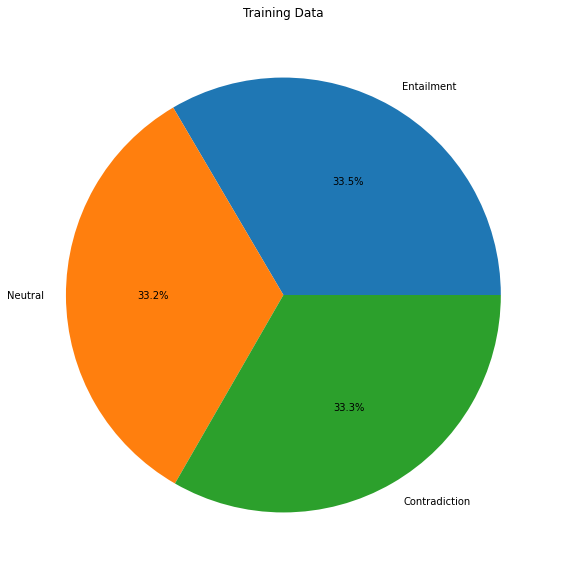

In [13]:
# check distribution of target classes in the augmented data
counts = train['label'].value_counts()

class_labels = ['Entailment', 'Neutral', 'Contradiction']

counts_per_class = [counts[0], counts[1], counts[2]]

plt.figure(figsize = (10,10))
plt.pie(counts_per_class, labels = class_labels, autopct = '%1.1f%%')
plt.title("Training Data")
plt.show()

# Split training dataset

In [14]:
train, test = train_test_split(train,
                                stratify=train.label.values,
                                random_state=42,
                                test_size=0.2,
                                shuffle=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [15]:
display(train.shape)
display(test.shape)

(335375, 3)

(83844, 3)

# BERT-uncased Tokenizer

In [16]:
model_class = TFBertModel
tokenizer_class = BertTokenizer
model_name ='bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name, num_labels=3)

save_path= '.'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)
tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=True, strip_accents=True, handle_chinese_chars=False)

tokenizer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=False, strip_accents=True, lowercase=True, wordpieces_prefix=##)

# save tokeinzer

In [17]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Visualize Tokenized Sequences

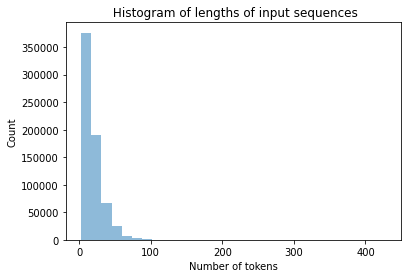

In [18]:
def plot(df, tokenizer):
    all_text = df.premise.values.tolist() + df.hypothesis.values.tolist()
    all_text_tokenized = tokenizer.encode_batch(all_text)
    all_tokenized_len = [len(encoding.tokens) for encoding in all_text_tokenized]
    
    plt.hist(all_tokenized_len, bins=30, alpha=0.5)
    plt.title(' Histogram of lengths of input sequences')
    plt.xlabel('Number of tokens')
    plt.ylabel('Count')

    plt.show()

plot(train, tokenizer)

In [19]:
tokenized_premise = tokenizer.encode_batch(train.premise.values.tolist())
train['premise_seq_length'] = [len(encoding.tokens) for encoding in tokenized_premise]

tokenized_hypothesis = tokenizer.encode_batch(train.hypothesis.values.tolist())
train['hypothesis_seq_length'] = [len(encoding.tokens) for encoding in tokenized_hypothesis]

info_per_lang = train.agg({'premise_seq_length': ['mean', 'max', 'count'], 'hypothesis_seq_length': ['mean', 'max', 'count']})
print (info_per_lang)

       premise_seq_length  hypothesis_seq_length
mean            26.688397              14.212231
max            428.000000              77.000000
count       335375.000000          335375.000000


# Hyperparameters Settings

In [20]:
EPOCHS = 100
BATCH_SIZE = 256
MAX_LEN = 100
PATIENCE = 5
LEARNING_RATE = 1e-5

# Encoding Sequences

In [21]:
def encode(df, tokenizer, max_len=100):
    pairs = df[['premise', 'hypothesis']].values.tolist()
    
    #check "BertTokenizer" do_lower_case = true
    tokenizer.enable_truncation(max_len)
    tokenizer.enable_padding()
    
    enc_list = tokenizer.encode_batch(pairs)
    input_word_ids = tf.ragged.constant([enc.ids for enc in enc_list], dtype=tf.int32)
    input_mask = tf.ragged.constant([enc.attention_mask for enc in enc_list], dtype=tf.int32)
    input_type_ids = tf.ragged.constant([enc.type_ids for enc in enc_list], dtype=tf.int32)
    
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask.to_tensor(),
        'input_type_ids': input_type_ids.to_tensor()}
    
    return inputs 


In [22]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)
train_ids = train_input['input_word_ids']
train_mask = train_input['input_mask']
train_type = train_input['input_type_ids']
train_labels = train.label.values

In [23]:
test_input = encode(test, tokenizer=tokenizer, max_len=MAX_LEN)
test_ids = test_input['input_word_ids']
test_mask = test_input['input_mask']
test_type = test_input['input_type_ids']
test_labels = test.label.values

In [24]:
display(test_input['input_word_ids'])
display(test_input['input_mask'])
display(test_input['input_type_ids'])
display(test_labels)

<tf.Tensor: shape=(83844, 100), dtype=int32, numpy=
array([[  101,  2059,  1996, ...,     0,     0,     0],
       [  101,  2027,  1005, ...,     0,     0,     0],
       [  101,  2092,  1010, ...,     0,     0,     0],
       ...,
       [  101, 19186,  1005, ...,     0,     0,     0],
       [  101,  2016,  2001, ...,     0,     0,     0],
       [  101,  2214,  2273, ...,     0,     0,     0]], dtype=int32)>

<tf.Tensor: shape=(83844, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

<tf.Tensor: shape=(83844, 100), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

array([1, 2, 0, ..., 2, 2, 0])

# Save tokenizer

In [25]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load and Process the Data in batches

In [26]:
def create_dataset(features, labels, batch_size=BATCH_SIZE, validation=False):
    AUTO = tf.data.experimental.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(len(features))
    if validation:
        dataset = dataset.batch(batch_size).prefetch(AUTO)
    else:
        dataset = dataset.repeat().batch(batch_size).prefetch(AUTO)
    return dataset

In [27]:
training_data = create_dataset((train_ids, train_mask, train_type), train_labels, batch_size=BATCH_SIZE)
testing_data = create_dataset((test_ids, test_mask, test_type), test_labels, batch_size=BATCH_SIZE, validation=True)

# Create & Train Model

In [28]:
def build_model(model_name, model_class, max_len=50, add_input_type=False):
    tf.random.set_seed(123)
    
    encoder = model_class.from_pretrained(model_name)
    
    input_word_ids = tf.keras.Input(shape=(max_len,),
                                    dtype=tf.int32,
                                    name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,),
                                dtype=tf.int32,
                                name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,),
                                    dtype=tf.int32,
                                    name="input_type_ids")
    
    if add_input_type:
        features = encoder([input_word_ids, input_mask, input_type_ids])[0]
    else:
        features = encoder([input_word_ids, input_mask])[0]
    
    vector = tf.keras.layers.GlobalAveragePooling1D()(features)
    vector = tf.keras.layers.Dense(32, activation='relu')(vector)
    vector = tf.keras.layers.Dropout(0.5)(vector)
   
    output = tf.keras.layers.Dense(3, activation="softmax")(vector) 

    if add_input_type:
        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    else:
        model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
        
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

In [29]:
with strategy.scope():
    model = build_model(model_name,
                        model_class,
                        MAX_LEN,
                        add_input_type=True)
    model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


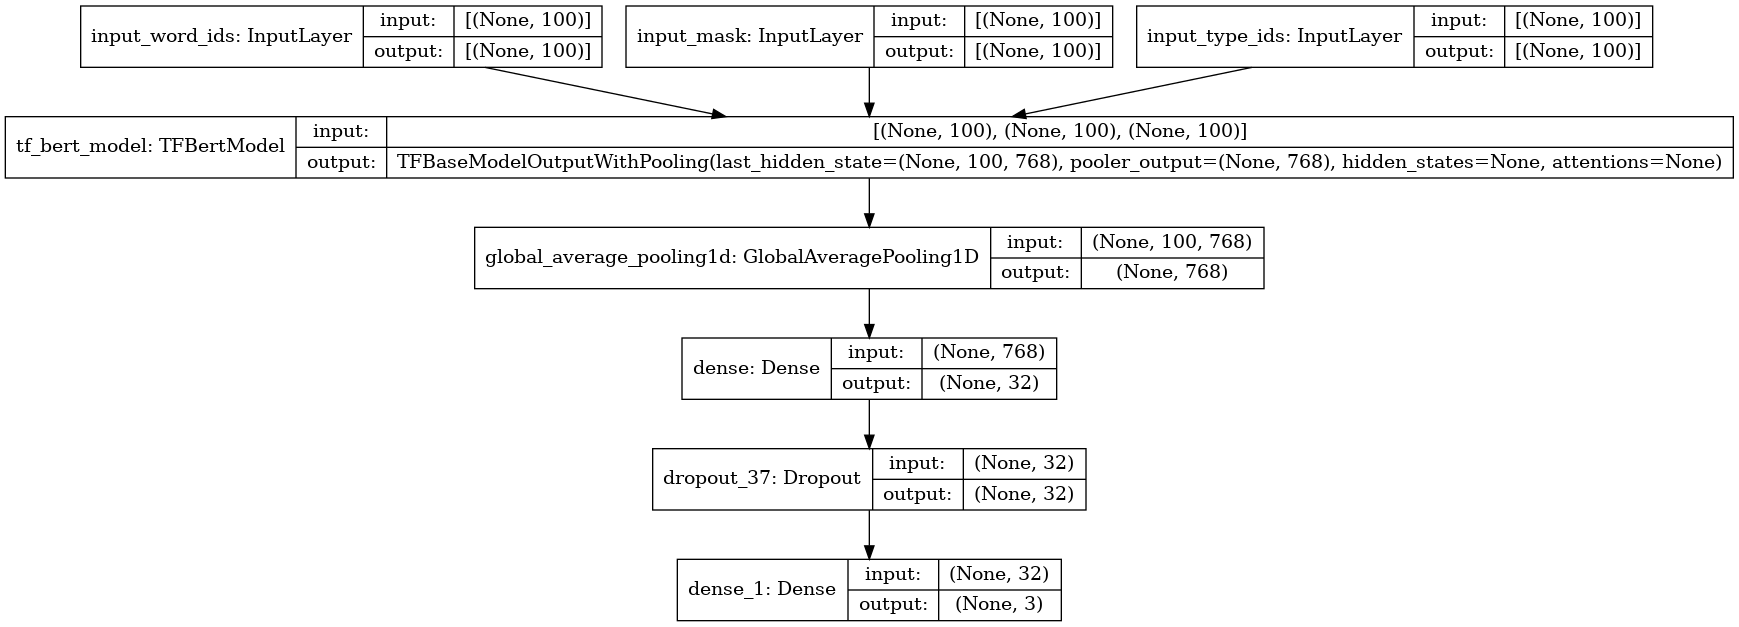

In [30]:
plot_model(model, to_file='model.png', show_shapes=True)

In [31]:
checkpoint_filepath='bert_best_checkpoint.hdf5'

callbacks = [EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=PATIENCE,
                           min_delta=0.01),
             ModelCheckpoint(filepath=checkpoint_filepath,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)]

n_steps = int(train_ids.shape[0]/BATCH_SIZE)
train_history = model.fit(x=training_data,
                          validation_data=testing_data,
                          epochs=EPOCHS,
                          verbose=1,
                          steps_per_epoch=n_steps,
                          callbacks=callbacks)

Epoch 1/100
1310/1310 [==============================] - 254s 143ms/step - loss: 0.8129 - accuracy: 0.6241 - val_loss: 0.5074 - val_accuracy: 0.7992

Epoch 00001: val_loss improved from inf to 0.50738, saving model to bert_best_checkpoint.hdf5
Epoch 2/100
1310/1310 [==============================] - 173s 132ms/step - loss: 0.5465 - accuracy: 0.7924 - val_loss: 0.4715 - val_accuracy: 0.8180

Epoch 00002: val_loss improved from 0.50738 to 0.47148, saving model to bert_best_checkpoint.hdf5
Epoch 3/100
1310/1310 [==============================] - 174s 133ms/step - loss: 0.4722 - accuracy: 0.8237 - val_loss: 0.4620 - val_accuracy: 0.8250

Epoch 00003: val_loss improved from 0.47148 to 0.46197, saving model to bert_best_checkpoint.hdf5
Epoch 4/100
1310/1310 [==============================] - 173s 132ms/step - loss: 0.4155 - accuracy: 0.8475 - val_loss: 0.4654 - val_accuracy: 0.8288

Epoch 00004: val_loss did not improve from 0.46197
Epoch 5/100
1310/1310 [==============================] - 17

# Plot Training and Validation Losses over all Epochs

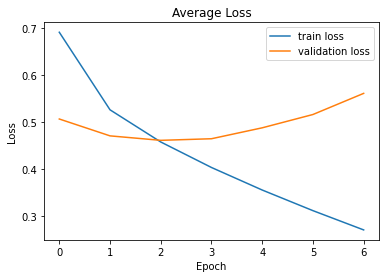

In [32]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Average Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_history)

# Plot Training and Validation Accuracies over all Epochs

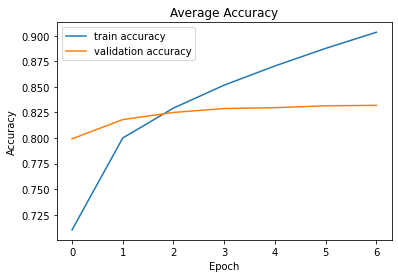

In [33]:
def plot_acc(history):
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Average Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_acc(train_history)

In [34]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)
prediction = model.predict(validation_input)

In [35]:
validation_predictions = [np.argmax(i) for i in model.predict(validation_input)]
validation['prediction'] = validation_predictions
validation_labels.head()

,prediction
0,1
1,1
2,1
3,1
4,1


In [36]:
sum = 0 
size = validation.shape[0]
for i in range(size):
    sum = sum + (validation['prediction'][i] == validation_labels['prediction'][i])
print("Correct:", sum)
print("Total:", size)
print("Accuracy:", sum/size)

Correct: 940
Total: 2945
Accuracy: 0.31918505942275044


# Confusion Matrix


Classification Report
               precision    recall  f1-score   support

contradiction       0.00      0.00      0.00         0
   entailment       0.00      0.00      0.00         0
      neutral       1.00      0.32      0.48      2945

     accuracy                           0.32      2945
    macro avg       0.33      0.11      0.16      2945
 weighted avg       1.00      0.32      0.48      2945



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


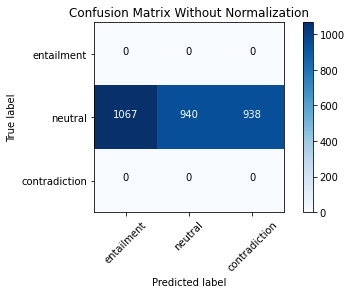

In [37]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm_plot_labels = ['entailment','neutral', 'contradiction']
cm = confusion_matrix(y_true=validation_labels, y_pred=validation_predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix Without Normalization')
# plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix With Normalization', normalize=True)

target_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_labels['prediction']]
prediction_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_predictions]
#display(validation_labels)
#display(validation_predictions)
#display(target_class)
#display(prediction_class)
print('\nClassification Report')
print(classification_report(y_true=target_class, y_pred=prediction_class))

# save model & test

In [53]:
with strategy.scope():
    new_model = build_model(model_name,
                        model_class,
                        MAX_LEN,
                        add_input_type=True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [54]:
new_model.load_weights('/kaggle/working/bert_best_checkpoint.hdf5')

In [63]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)
prediction = new_model.predict(validation_input)

validation_predictions = [np.argmax(i) for i in new_model.predict(validation_input)]
validation['prediction'] = validation_predictions
validation_labels.head()

sum = 0 
size = validation.shape[0]
for i in range(size):
    sum = sum + (validation['prediction'][i] == validation_labels['prediction'][i])
print("Correct:", sum)
print("Total:", size)
print("Accuracy:", sum/size)

Correct: 953
Total: 2945
Accuracy: 0.3235993208828523
